#### Szybkie algorytmy konwolucji

In [1]:
using TestImages, Colors, PyPlot, ProgressMeter

#### Operacja splotu
Dzisiaj przyjrzymy się ciekawemu narzędziu, czyli _konwolucji_.

W większości przypadków mówiąc o splocie (to inna nazwa konwolucji) mamy na myśli, np. nakładanie filtru na obraz lub przetwarzanie dźwięku.

Dlatego rozpoczniemy od przygotowania typowego obrazu kamerzysty.

In [2]:
using FFTW, SparseArrays, BenchmarkTools, StaticArrays

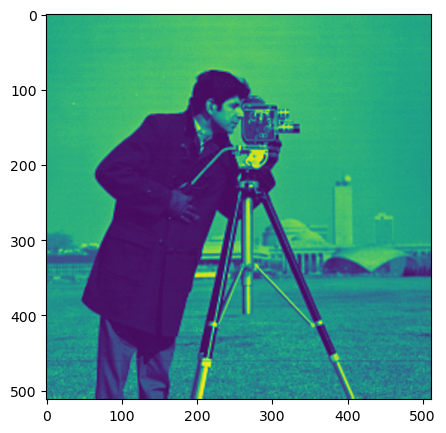

PyObject <matplotlib.image.AxesImage object at 0x13a28f340>

In [3]:
cameraman = testimage("cameraman") .|> Float64

figure(figsize=(5, 5))
imshow(cameraman)

In [4]:
size(cameraman)

(512, 512)

Zdefiniujmy teraz naiwną funkcję, która oblicza splot maski `K` z obrazem `I`.

In [5]:
function conv(I :: Array{Float64,1}, K :: Array{Float64, 1})
	n = length(I) - 1
	J = zeros(n+1)
	for i=2:n
		J[i] = sum(I[i-1:i+1] .* K)
	end

	return J
end

conv (generic function with 1 method)

In [6]:
function conv(I :: Array{Float64, 2}, K :: Array{Float64, 2})
	n, m = size(I) .- 1
	J = zeros(n+1, m+1)
	for i=2:n, j=2:m
		J[i, j] = sum(I[i-1:i+1, j-1:j+1] .* K)
	end
	
	return J
end

conv (generic function with 2 methods)

In [7]:
function conv(I :: Array{Float64, 3}, K :: Array{Float64, 3})
	n, m, _ = size(I) .- 1
	l = size(I, 3)
	J = zeros(n+1, m+1)
	for i=2:n, j=2:m, k=1:l
		J[i, j] = sum(I[i-1:i+1, j-1:j+1, 1:l] .* K)
	end
	
	return J
end

conv (generic function with 3 methods)

Sprawdźmy jak mogą wyglądać efekty takiej operacji dla maski:

$ K = 
  \begin{bmatrix}
    1/9 & 1/9 & 1/9 \newline
    1/9 & 1/9 & 1/9 \newline
    1/9 & 1/9 & 1/9
\end{bmatrix} $.

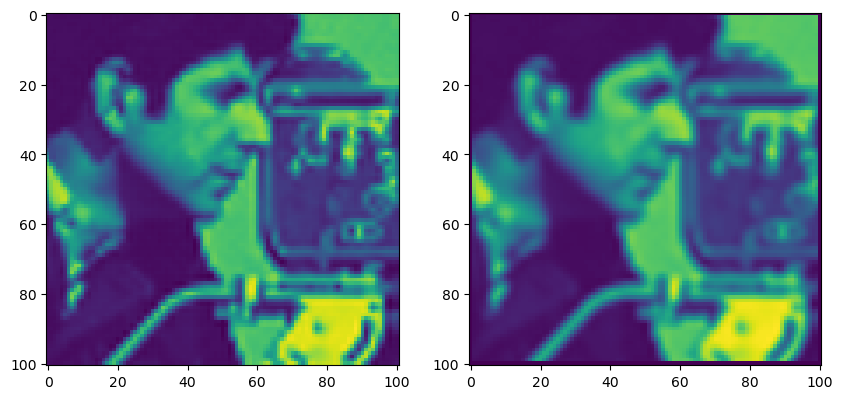

PyObject <matplotlib.image.AxesImage object at 0x15a28dbd0>

In [8]:
img = cameraman[100:200, 200:300]

figure(figsize=(10, 5))
subplot(1, 2, 1); imshow(img)
subplot(1, 2, 2); imshow(conv(img, [1/9 1/9 1/9; 1/9 1/9 1/9; 1/9 1/9 1/9]))

Możemy też spróbować inne jądro. Jest to tzw. operator Sobela, służący do wykrywania krawędzi.

$ K = 
  \begin{bmatrix}
    -1 & -2 & -1 \newline
     0 &  0 &  0 \newline
    +1 & +2 & +1
\end{bmatrix} $ lub $ K = 
  \begin{bmatrix}
    -1 &  0 & +1 \newline
    -2 &  0 & +2 \newline
    -1 &  0 & +1
\end{bmatrix} $.

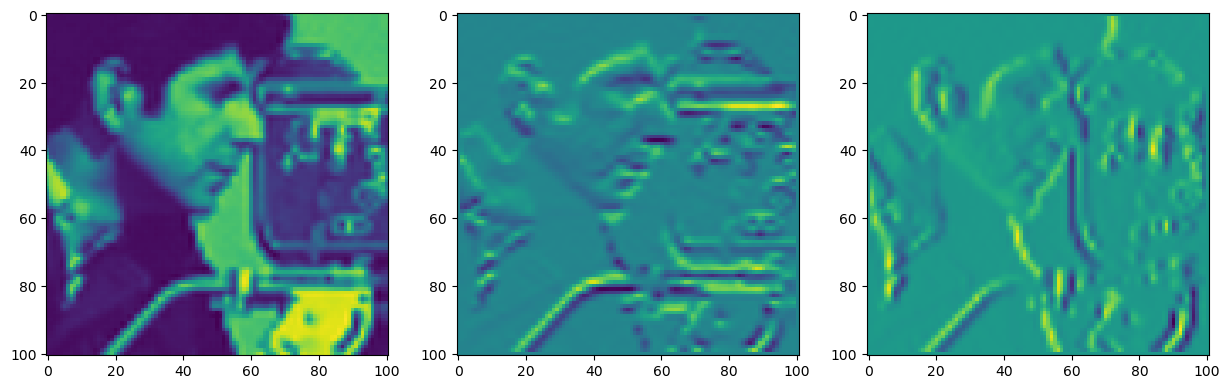

PyObject <matplotlib.image.AxesImage object at 0x15d8eac50>

In [9]:
img = cameraman[100:200, 200:300]
	
figure(figsize=(15, 5))
subplot(1, 3, 1); imshow(img)
subplot(1, 3, 2); imshow(conv(img, [-1 -2 -1; 0 0.  0; +1 +2 +1]))
subplot(1, 3, 3); imshow(conv(img, [-1  0 +1;-2 0. +2; -1  0 +1]))

#### Automaty komórkowe
Zasady automatów komórkowych można potraktować jako operację splotu na
siatce/planszy. Jako przykład zaimplementujemy Grę w Życie Johna Conwaya.

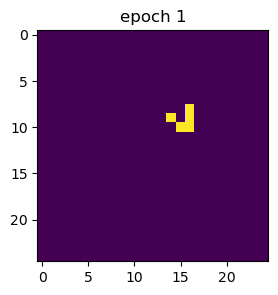

PyObject Text(0.5, 1.0, 'epoch 1')

In [16]:
N = 24

glider = [0 0 1
	  	  1 0 1
	  	  0 1 1]

beard = [1 1 0 1 1
	 	 1 0 0 0 1
	 	 0 1 1 1 0]

ls = zeros(N+1, N+1, 50)
#ls[9:11,15:19,1] .= beard
ls[9:11,15:17,1] .= glider
M = [1  1  1
	 1 10. 1
 	 1  1  1]
	
gol(n) = (n == 3) || (12 <= n <= 13) ? 1 : 0
epoch = 1
figure(figsize=(3,3))
imshow(ls[:,:,epoch])
title("epoch $epoch")

In [17]:
@showprogress for t=2:50
	ls[:, :, t] .= gol.(conv(ls[:, :, t-1], M))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


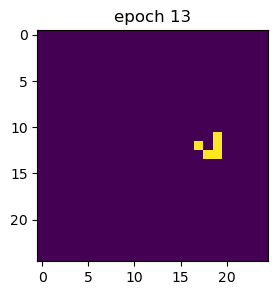

14

In [30]:
figure(figsize=(3,3))
imshow(ls[:,:,epoch])
title("epoch $epoch")
epoch += 1

#### Równania różniczkowe cząstkowe
Spróbujmy teraz sami stworzyć obraz. Niech będzie to koło o promieniu 0.2 _m_.

In [31]:
N = 31
x = repeat(0:1/N:1, 1, N+1)
y = rotr90(x)
r = sqrt.((x .- 0.5).^2 .+ (y .- 0.69).^2)
u = r .< 0.20

g(r, ct) = exp.(-200(r .- ct).^2)

g (generic function with 1 method)

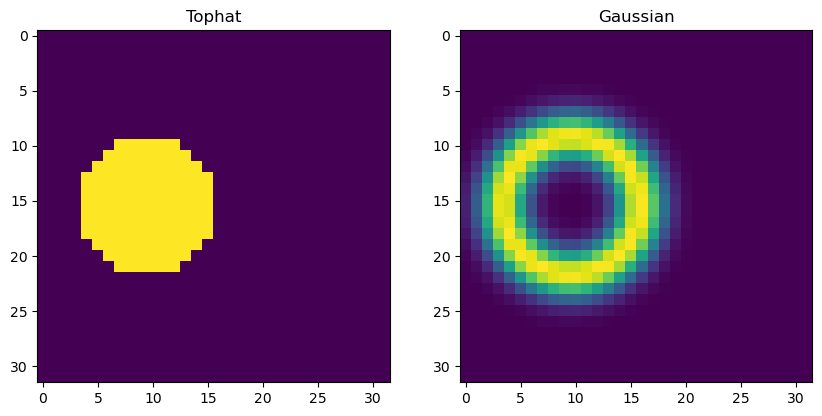

PyObject <matplotlib.image.AxesImage object at 0x15dbe8ee0>

In [32]:
figure(figsize=(10, 5))
subplot(1,2,1); title("Tophat"); imshow(u)
subplot(1,2,2); title("Gaussian"); imshow(g(r, 0.2))

Niech ten obraz będzie pierwszym na "stosie" obrazów. Każdy kolejny powstanie jako nałożenie na ostatni obraz wyniku jego konwolucji z jądrem:

$ K = 
  \alpha\begin{bmatrix}
    0 & 1 & 0 \newline
    1 &-4 & 1 \newline
    0 & 1 & 0
\end{bmatrix} + \begin{bmatrix}
    0 & 0 & 0 \newline
    0 & 1 & 0 \newline
    0 & 0 & 0
\end{bmatrix}$, gdzie współczynnik $ \alpha \approx 0.00961$

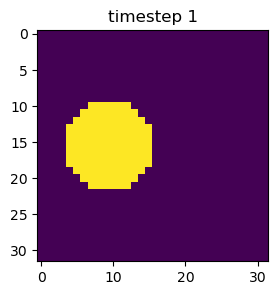

PyObject Text(0.5, 1.0, 'timestep 1')

In [33]:
T  = 150
Δt = 1e-4
Δx = 1.0 / N
α  = .1Δt / Δx^2

us = zeros(N+1, N+1, T)
us[:, :, 1] = u

D = zeros(3, 3, 1)
D[:, :, 1] =[0  1  0
			 1 -4. 1
			 0  1  0] * α
D[2, 2, 1]+= 1.0

timestep = 1
figure(figsize=(3,3))
imshow(us[:, :, timestep])
title("timestep $timestep")

In [34]:
@showprogress for t=2:T
	us[:, :, t] .= conv(us[:, :, t-1:t-1], D) 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


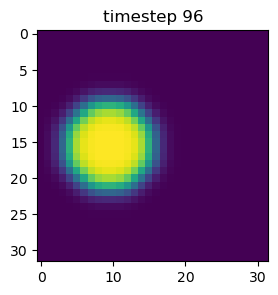

101

In [54]:
figure(figsize=(3,3))
imshow(us[:, :, timestep])
title("timestep $timestep")
timestep += 5

Zmodyfikujmy delikatnie jądro splotu. Otrzymamy wtedy "trochę" inne zachowanie.

$ K = 
  \beta\begin{bmatrix}
    0 & 1 & 0 \newline
    1 &-2 & 0 \newline
    0 & 0 & 0
\end{bmatrix} + \begin{bmatrix}
    0 & 0 & 0 \newline
    0 & 1 & 0 \newline
    0 & 0 & 0
\end{bmatrix} $, gdzie współczynnik $ \beta \approx 0.0465$

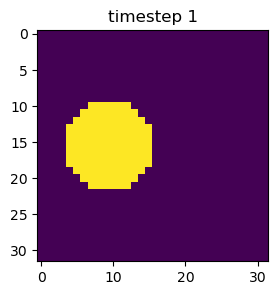

PyObject Text(0.5, 1.0, 'timestep 1')

In [55]:
# advection equation
β = 15Δt / Δx

vs = zeros(N+1, N+1, T)
vs[:, :, 1] = u

A = zeros(3, 3, 1)
A[:, :, 1] =[0  1  0
			 1 -2. 0
			 0  0  0] * β
A[2, 2, 1]+= 1.0

timestep = 1
figure(figsize=(3,3))
imshow(vs[:, :, timestep])
title("timestep $timestep")

In [56]:
@showprogress for t=2:T
	vs[:, :, t] .= conv(vs[:, :, t-1:t-1], A) 
end

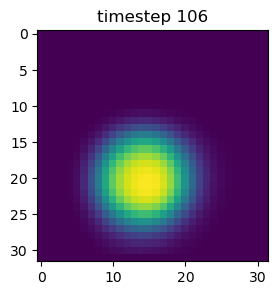

111

In [78]:
figure(figsize=(3,3))
imshow(vs[:, :, timestep])
title("timestep $timestep")
timestep += 5

A teraz mój ulubiony przykład! Zwróćmy uwagę, że teraz zaczynamy uzupełniać stos obrazów od trzeciego, ponieważ wymagamy *dwóch* obrazów wstecz.

$ K = 
  c^2\begin{bmatrix}
    0 & 1 & 0 \newline
    1 &-4 & 1 \newline
    0 & 1 & 0
\end{bmatrix} + \begin{bmatrix}
    0 & 0 & 0 \newline
    0 & 2 & 0 \newline
    0 & 0 & 0
\end{bmatrix}$, gdzie współczynnik $ c^2 \approx 0.0961 $

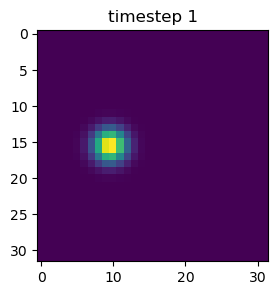

PyObject Text(0.5, 1.0, 'timestep 1')

In [79]:
# wave equation
c = 100Δt / Δx

ws = zeros(N+1, N+1, T)
ws[:, :, 1] = g(r, .0 + .0*c)
ws[:, :, 2] = g(r, .0 + Δt*c)

W = zeros(3, 3, 2)
W[:, :, 2] =[0  1  0
			 1 -4. 1
			 0  1  0] * c^2
W[2, 2, 2]+= 2.0
W[2, 2, 1]-= 1.0

timestep = 1
figure(figsize=(3,3))
imshow(ws[:, :, timestep])
title("timestep $timestep")

In [80]:
@showprogress for t=3:T
	ws[:, :, t] .= conv(ws[:, :, t-2:t-1], W) 
end

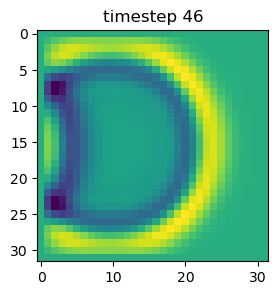

51

In [90]:
figure(figsize=(3,3))
imshow(ws[:, :, timestep])
title("timestep $timestep")
timestep += 5

In [91]:
slice = 1

1

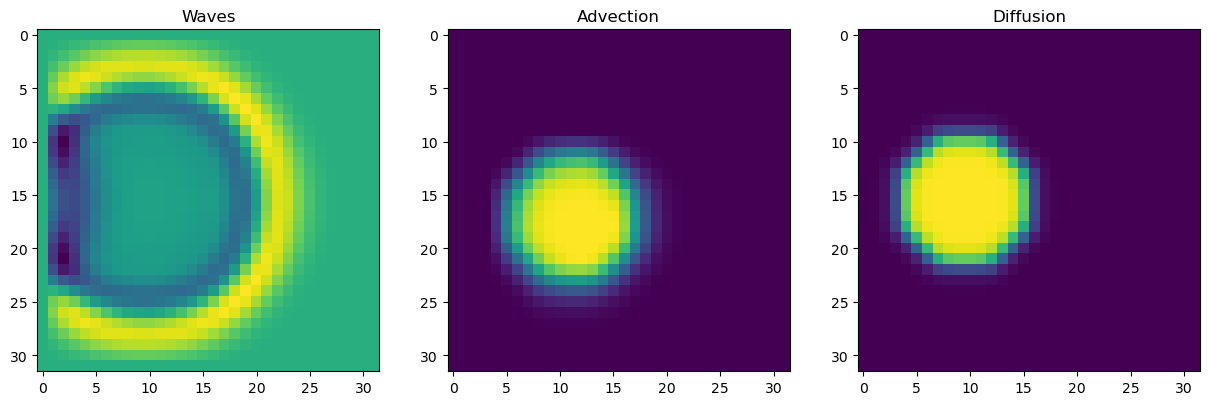

46

In [100]:
figure(figsize=(15, 5))
subplot(1,3,1); title("Waves");     imshow(ws[:, :, slice])
subplot(1,3,2); title("Advection"); imshow(vs[:, :, slice])
subplot(1,3,3); title("Diffusion"); imshow(us[:, :, slice])
slice += 5

Poprzednie równania charakteryzowało to, że polegały one na wcześniejszym "stanie", który ulegał zmianie zgodnie z postacią równania.
Inaczej ma miejsce w przypadku równania Poissona, które jest niezmiennicze w czasie (opisuje stan ustalony).

Natomiast, możliwe jest zapisanie procesu iteracyjnego pozwalającego na rozwiązanie równania Poissona. W poniższym przykładzie wykorzystamy iterację Jacobiego.

$ K = 
  \frac{1}{4}\begin{bmatrix}
    0 & 1 & 0 \newline
    1 & 0 & 1 \newline
    0 & 1 & 0
\end{bmatrix} $.

In [101]:
# Poisson equation (Jacobi iteration) 0.996581*
ps = zeros(N+1, N+1, 1500)
b  =-8π^2 * sin.(2π.*x).*sin.(2π.*y) * Δx^2
ps[:, :, 1] = randn(N+1, N+1)

P = [ 0 1 0
	  1 0 1
	  0 1 0.]

for t=2:1500
	ps[:, :, t] .= conv(ps[:, :, t-1], P) .- b
	ps[:, :, t]./= 4
end

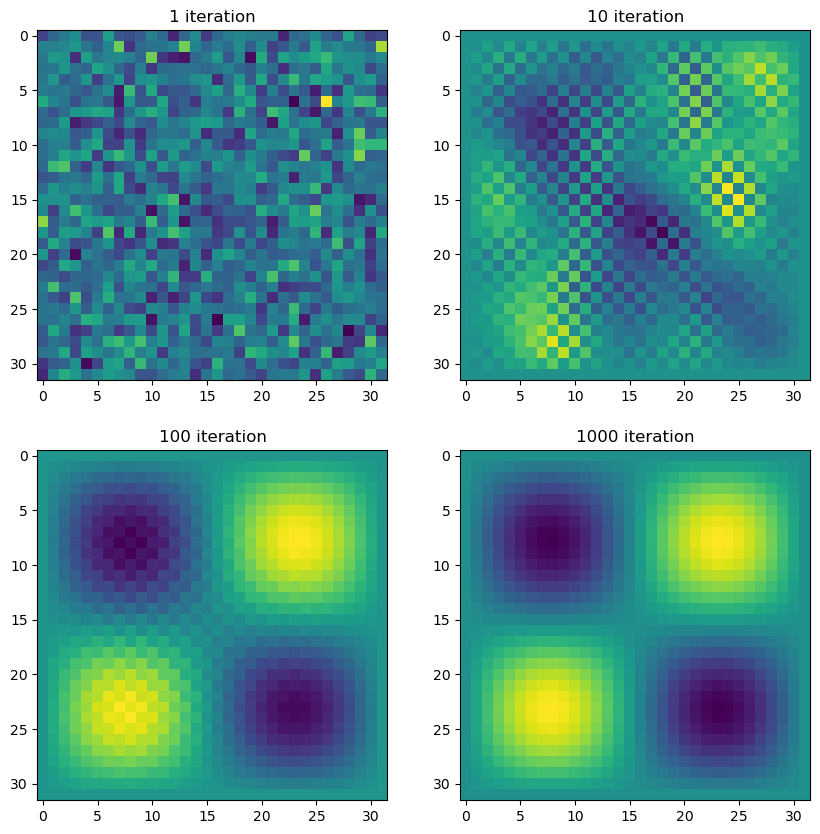

PyObject <matplotlib.image.AxesImage object at 0x160127b80>

In [102]:
figure(figsize=(10, 10))
subplot(2, 2, 1); title("1 iteration"); imshow(ps[:, :, 1])
subplot(2, 2, 2); title("10 iteration"); imshow(ps[:, :, 10])
subplot(2, 2, 3); title("100 iteration"); imshow(ps[:, :, 100])
subplot(2, 2, 4); title("1000 iteration"); imshow(ps[:, :, 1000])

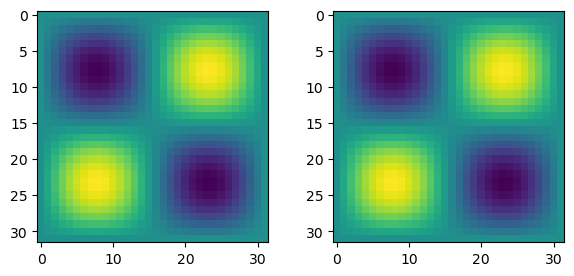

PyObject <matplotlib.image.AxesImage object at 0x160306dd0>

In [103]:
pexact(x, y) = sin(2π*x)*sin(2π*y)
it = 700
figure(figsize=(7, 3))
subplot(1,2,1); imshow(ps[:, :, it])
subplot(1,2,2); imshow(pexact.(x, y))

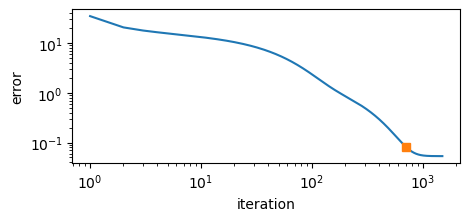

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1603ecd60>
 PyObject <matplotlib.lines.Line2D object at 0x1603ecd90>

In [104]:
import LinearAlgebra: norm
err = Float64[]
for i=1:1500
	push!(err, norm(ps[:, :, i] .- pexact.(x, y)))
end
figure(figsize=(5, 2))
xlabel("iteration")
ylabel("error")
loglog(1:1500, err, [it;], [err[it];], "s")    

Jakość rozwiązania może rozczarowywać, jednak jest to wartość *błędu* a nie *normy wektora residualnego*.

Podobne wyniki osiągają w [NeuralPDE.jl](https://neuralpde.sciml.ai/dev/pinn/poisson/).

In [105]:
function mulconv(img :: Array{Float64, 2}, kernel :: Array{Float64, 2})
	n, m = size(img)
	I = reshape(img, :, 1)
	K = spdiagm(0 => kernel[2,2]*ones(n*m),
			 -1   => kernel[2,1]*ones(n*m-1),
			 +1   => kernel[2,3]*ones(n*m-1),
			 -m   => kernel[1,2]*ones(n*m-m),
			 +m   => kernel[3,2]*ones(n*m-m),
			 -m-1 => kernel[1,1]*ones(n*m-m-1),
			 -m+1 => kernel[1,3]*ones(n*m-m-1),
			 +m-1 => kernel[3,1]*ones(n*m-m-1),
			 +m+1 => kernel[3,3]*ones(n*m-m-1))
	reshape(K * I, n, m)
end

# Autor: Seif_Shebl
# https://discourse.julialang.org/t/what-is-julias-im2col/14066/9
@inline function im2col(A, n, m)
	M,N = size(A)
	B = Array{eltype(A)}(undef, m*n, (M-m+1)*(N-n+1))
	indx = reshape(1:M*N, M,N)[1:M-m+1,1:N-n+1]
	for (i,value) in enumerate(indx)
		for j = 0:n-1
		@views B[(i-1)*m*n+j*m+1:(i-1)m*n+(j+1)m] = A[value+j*M:value+m-1+j*M]
		end
	end
	return B'
end

@inline function _im2col(A, n, m)
	B = Array{eltype(A)}(undef, 3*3, n*m)
	for i=1:m, j=1:n
		b = view(A, i:i+2, j:j+2)
		B[:, i*n-m+j] = reshape(b, :)
	end
	return B
end
	

function matconv(img :: Array{Float64, 2}, kernel :: Array{Float64, 2})
	n, m = size(img) .- 2
	I = im2col(img, n, m)
	K = reshape(kernel, 1, :)
	reshape(K * I, n, m)
end

function fftconv(img :: Array{Float64, 2}, kernel :: Array{Float64, 2})
	ker = zero(img); ker[1:3, 1:3] .= kernel
	I = fft(img)
	K = fft(ker)
	J = ifft(I .* K)
	return abs.(J)
end

fftconv (generic function with 1 method)

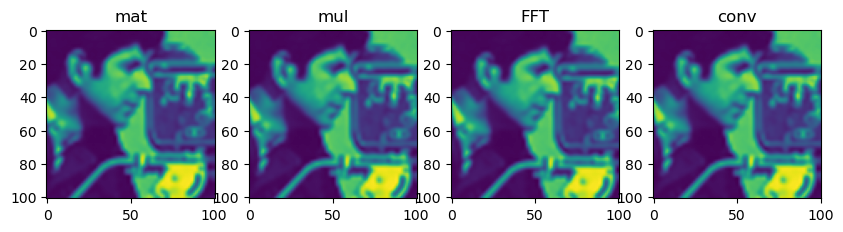

PyObject <matplotlib.image.AxesImage object at 0x15ffc4040>

In [109]:
using BenchmarkTools
img = cameraman[1:512, 1:512]
kernel = [1/9 1/9 1/9; 1/9 1/9 1/9; 1/9 1/9 1/9]

res = matconv(img, kernel)
ult = mulconv(img, kernel)
ima = fftconv(img, kernel)
ges =    conv(img, kernel)

figure(figsize=(10, 3))
subplot(1, 4, 1); title("mat");   imshow(res[100:200, 200:300])
subplot(1, 4, 2); title("mul");   imshow(ult[100:200, 200:300])
subplot(1, 4, 3); title("FFT");   imshow(ima[100:200, 200:300])
subplot(1, 4, 4); title("conv");  imshow(ges[100:200, 200:300])

In [107]:
using BenchmarkTools
kernel = [1/9 1/9 1/9; 1/9 1/9 1/9; 1/9 1/9 1/9]

t = zeros(10, 4)
s = zeros(10)
@showprogress for i=1:10
	img = zeros(10i, 10i)
	t[i, 1] = @belapsed matconv(img, kernel)
	t[i, 2] = @belapsed mulconv(img, kernel)
	t[i, 3] = @belapsed fftconv(img, kernel)
	t[i, 4] = @belapsed    conv(img, kernel)
	s[i]    = (10i * 10i)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:04


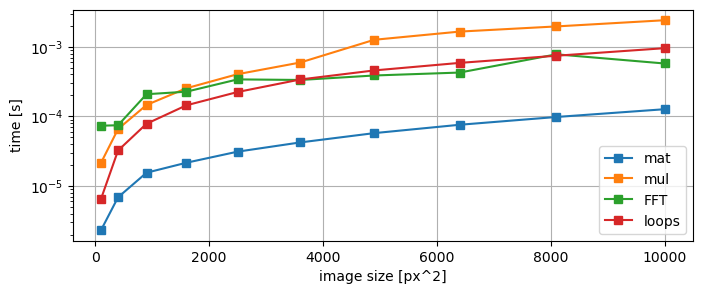

PyObject <matplotlib.legend.Legend object at 0x16026a470>

In [108]:
figure(figsize=(8, 3))
xlabel("image size [px^2]"); ylabel("time [s]"); grid()
semilogy(s, t[:, 1], "s-")
semilogy(s, t[:, 2], "s-")
semilogy(s, t[:, 3], "s-")
semilogy(s, t[:, 4], "s-")
legend(("mat", "mul", "FFT", "loops"))